# Artificial Neural Networks (ANN) Basics: Error Back Propagation

## Table of Content <a name="TOC"></a>

1. [General setups](#setups)

2. [Creation and initialization. Data members](#creation) 

3. [Saving and loading ANNs](#save_load)

4. [Training](#training) 

5. [Error tracking](#errors)


### A. Learning objectives

- to create an ANN of arbitrary architecture
- to initialize the ANN parameters
- to construct an ANN training algorithm
- to save and load the ANN state
- to know the difference between the online and batch training of an ANN
- to train ANN and track the progress
- to track errors of the ANN training
- to predict the outputs using the ANN and known inputs

### B. Use cases

- [Deep machine learning: Multilayer Perceptron](#mlp-1)
- [Constructing ANN from file](#save_load-1)


### C. Functions

- `liblibra::liblinalg`
  - [`pop_submatrix`](#pop_submatrix-1)

- `liblibra::libspecialfunctions`
  - [`randperm`](#randperm-1) | [also here](#randperm-2)

  
### D. Classes and class members

- `liblibra::libann`
  - [`NeuralNetwork`](#NeuralNetwork-1) | [also here](#NeuralNetwork-1)
    - [`Nlayers`](#Nlayers-1)  
    - [`Npe`](#Npe-1)
    - [`W`](#W-1) | [also here](#W-2)
    - [`dW`](#dW-1)
    - [`dWold`](#dWold-1)    
    - [`grad_w`](#grad_w-1) | [also here](#grad_w-2)
    - [`grad_w_old`](#grad_w_old-1)
    - [`B`](#B-1) | [also here](#B-2)
    - [`dB`](#dB-1)
    - [`dBold`](#dBold-1)
    - [`grad_b`](#grad_b-1) | [also here](#grad_b-2)
    - [`grad_b_old`](#grad_b_old-1)
    - [`propagate`](#propagate-1) | [also here](#propagate-2)
    - [`back_propagate`](#back_propagate-1) | [also here](#back_propagate-2)
    - [`save`](#save-1)
    - [`load`](#load-1)
    - [`init_weights_biases_uniform`](#init_weights_biases_uniform-1)
    - [`init_weights_biases_normal`](#init_weights_biases_normal-1)
    - [`train`](#train-1)    
    - [`error`](#error-1)

- `liblibra::librandom`
  - [`Random`](#Random-1)    
    - [`normal`](#normal-1)
    

## 1. General setups
<a name="setups"></a> [Back to TOC](#TOC)

In [1]:
import math
import sys
import cmath
import math
import os

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
import util.libutil as comn

from libra_py import units
from libra_py import data_outs
import matplotlib.pyplot as plt   # plots
#matplotlib.use('Agg')
#%matplotlib inline 

import numpy as np
#from matplotlib.mlab import griddata

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

## 2. Creation and initialization. Data members.
<a name="creation"></a> [Back to TOC](#TOC)

Create the ANN object with 3 layers: input, 1 hidden, and 1 output layers. 
<a name="NeuralNetwork-1"></a>

In [2]:
ANN = NeuralNetwork( Py2Cpp_int( [2, 5, 1] ) )

We can then check that:
    
* there are 3 layers
* the input layers has 2 neurons
* the hidden layer has 5 neurons
* the output has 1 neuron
<a name="Nlayers-1"></a><a name="Npe-1"></a>

In [3]:
print(F"Number of layers = {ANN.Nlayers}")
print(F"Input layer dimension = {ANN.Npe[0]}")
print(F"Hidden layer dimension = {ANN.Npe[1]}")
print(F"Output layer dimension = {ANN.Npe[2]}")

Number of layers = 3
Input layer dimension = 2
Hidden layer dimension = 5
Output layer dimension = 1


This operation simply creates a collection of the weights and biases, that are stored in the matrices `W` and `B` correspondingly

Also, this operation initializes the storage for the deltas of these parameters - `dW` and `dB`

Note that matrices `W[0]` and `B[0]` are irrelevant (junk), are not used and are only needed for the consistency of the implementation with the common ways the ANN theory is described in the literature
<a name="W-1"></a><a name="B-1"></a>

In [4]:
print("W[0]"); data_outs.print_matrix(ANN.W[0])
print("W[1]"); data_outs.print_matrix(ANN.W[1])
print("W[2]"); data_outs.print_matrix(ANN.W[2])

print("B[0]"); data_outs.print_matrix(ANN.B[0])
print("B[1]"); data_outs.print_matrix(ANN.B[1])
print("B[2]"); data_outs.print_matrix(ANN.B[2])

W[0]
1.0  0.0  
0.0  1.0  
W[1]
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
W[2]
0.0  0.0  0.0  0.0  0.0  
B[0]
0.0  
0.0  
B[1]
0.0  
0.0  
0.0  
0.0  
0.0  
B[2]
0.0  


<a name="dWold-1"></a><a name="dBold-1"></a><a name="grad_w-1"></a><a name="grad_b-1"></a><a name="grad_w_old-1"></a><a name="grad_b_old-1"></a>
In addition, the `NeuralNetwork` class objects hold other variables:

* `dWold` and `dBold` - the deltas of weights and biases from the previous step
* `grad_w` and `grad_b` - the gradients of the total error function (cost function) w.r.t. the corresponding weights and biases.
* `grad_w_old` and `grad_b_old` - the gradients from the previous step

Here, we output just one of these matrices. Of course, these matrices are still zero, since no actual gradient calculations of steps of the training has been completed

In [5]:
print("dW[1]"); data_outs.print_matrix(ANN.dW[1])
print("dB[1]"); data_outs.print_matrix(ANN.dB[1])

print("dWold[1]"); data_outs.print_matrix(ANN.dWold[1])
print("dBold[1]"); data_outs.print_matrix(ANN.dBold[1])

print("grad_w[1]"); data_outs.print_matrix(ANN.grad_w[1])
print("grad_b[1]"); data_outs.print_matrix(ANN.grad_b[1])

print("grad_w_old[1]"); data_outs.print_matrix(ANN.grad_w_old[1])
print("grad_b_old[1]"); data_outs.print_matrix(ANN.grad_b_old[1])

dW[1]
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
dB[1]
0.0  
0.0  
0.0  
0.0  
0.0  
dWold[1]
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
dBold[1]
0.0  
0.0  
0.0  
0.0  
0.0  
grad_w[1]
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
grad_b[1]
0.0  
0.0  
0.0  
0.0  
0.0  
grad_w_old[1]
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
grad_b_old[1]
0.0  
0.0  
0.0  
0.0  
0.0  


Exercise 1 OR Gate


| Input A | Input B |  Output A and B |
| --- | --- | --- |
|  0  |  0  |  0  |
|  0  |  1  |  1  |
|  1  |  0  |  1  |
|  1  |  1  |  0  |

For the numerical convenience, the inputs and outputs are rescaled down to the [0.0, 0.5] range

The AND truth table can be summarized as 4 inputs and 4 outputs. Each input and output constitute a column of the corresponding matrix. The length of each column (the number of rows in the matrices) corresponds to the dimensionalty of the input (2 - for the A and B) and output (A and B representation)


In [23]:
inputs = MATRIX(2, 4)
outputs = MATRIX(1, 4)

# Pattern 0
inputs.set(0, 0, 0.0)
inputs.set(1, 0, 0.5)
outputs.set(0, 0, 0.5)

# Pattern 1
inputs.set(0, 1, 0.5)
inputs.set(1, 1, 0.0)
outputs.set(0, 1, 0.5)

# Pattern 2
inputs.set(0, 2, 0.0)
inputs.set(1, 2, 0.0)
outputs.set(0, 2, 0.0)

# Pattern 3
inputs.set(0, 3, 0.5)
inputs.set(1, 3, 0.5)
outputs.set(0, 3, 0.0)

Before we start, we need to initialize the values of the weights and biases of the ANN
<a name="Random-1"></a><a name="normal-1"></a>

In [7]:
rnd = Random()

for L in range(1, ANN.Nlayers):
    for i in range(ANN.Npe[L]):
        for j in range(ANN.Npe[L-1]):
            ANN.W[L].set(i, j, 0.1*rnd.normal())
        ANN.B[L].set(i, 0, 0.1*rnd.normal() )
        
print("W[0]"); data_outs.print_matrix(ANN.W[0])
print("W[1]"); data_outs.print_matrix(ANN.W[1])
print("W[2]"); data_outs.print_matrix(ANN.W[2])

print("B[0]"); data_outs.print_matrix(ANN.B[0])
print("B[1]"); data_outs.print_matrix(ANN.B[1])
print("B[2]"); data_outs.print_matrix(ANN.B[2])

W[0]
1.0  0.0  
0.0  1.0  
W[1]
-0.07477622111046436  0.08395055949535368  
-0.06434766339596208  -0.07365141637365749  
0.09341565459689222  -0.01689948763387337  
0.1547557965208588  0.08669922337979942  
0.18312862418540063  0.17260067582517552  
W[2]
-0.04538204939678809  -0.10064546134452718  -0.13108375773470865  -0.11929342294018336  -0.2104164161703214  
B[0]
0.0  
0.0  
B[1]
0.16595866588089658  
-0.04176419336060002  
0.13437233940011895  
0.013877779733474208  
0.20766988153254023  
B[2]
-0.07033053606495225  


This operation can also be done with the help of the auxiliary function `init_weights_biases_normal` or `init_weights_biases_uniform`:

    void init_weights_biases_uniform(Random& rnd, double left_w, double right_w, double left_b, double right_b);
    void init_weights_biases_normal(Random& rnd, double scaling_w, double shift_w, double scaling_b, double shift_b);
 
<a name="init_weights_biases_normal-1"></a>

In [8]:
ANN.init_weights_biases_normal(rnd, 0.1, 0.0, 0.1, 0.0)

print("W[0]"); data_outs.print_matrix(ANN.W[0])
print("W[1]"); data_outs.print_matrix(ANN.W[1])
print("W[2]"); data_outs.print_matrix(ANN.W[2])

print("B[0]"); data_outs.print_matrix(ANN.B[0])
print("B[1]"); data_outs.print_matrix(ANN.B[1])
print("B[2]"); data_outs.print_matrix(ANN.B[2])

W[0]
1.0  0.0  
0.0  1.0  
W[1]
0.07527230517978706  0.022031498744903302  
-0.16425312472467501  0.08467514393299172  
-0.010559248734041673  0.09015262815060981  
-0.21000583895578304  0.0648939759991747  
0.062099592148826224  0.06434395069103375  
W[2]
0.11461402592365191  0.09121337072615093  0.027191361927926923  0.12181633200119134  -0.09600636619256  
B[0]
0.0  
0.0  
B[1]
-0.08124118109423346  
0.23442900424232804  
-0.1438027070441978  
-0.07410769753918656  
0.0017155856537309742  
B[2]
0.14328738176910125  


Initialize the weights and biases using random numbers sampled from a uniform distribution.
<a name="init_weights_biases_uniform-1"></a>

In [9]:
ANN.init_weights_biases_uniform(rnd, -0.1, 0.1, -0.1, 0.1)

print("W[0]"); data_outs.print_matrix(ANN.W[0])
print("W[1]"); data_outs.print_matrix(ANN.W[1])
print("W[2]"); data_outs.print_matrix(ANN.W[2])

print("B[0]"); data_outs.print_matrix(ANN.B[0])
print("B[1]"); data_outs.print_matrix(ANN.B[1])
print("B[2]"); data_outs.print_matrix(ANN.B[2])

W[0]
1.0  0.0  
0.0  1.0  
W[1]
-0.054751709268778426  0.0962921458279212  
-0.09730533109852361  -0.05867930481148852  
0.023265211341560454  -0.020179074499839494  
-0.013230265543437689  0.08278720303568393  
0.03371601250661352  -0.02874963988026122  
W[2]
0.045229321506446846  -0.026118213183301597  0.02180477880025504  0.05060311926091235  0.06994463874490217  
B[0]
0.0  
0.0  
B[1]
-0.04750003197579647  
-0.08949619605648154  
-0.0826776044362586  
0.09226557947335093  
0.058773784879024044  
B[2]
-0.026668278745686766  


## 3. Saving and loading ANNs
<a name="save_load-1"></a> [Back to TOC](#TOC)

<a name="save-1"></a>
The state of the ANN can be saved into a file of XML format using the `save` function

In [10]:
ANN.save("my_ann.xml")

<a name="NeuralNetwork-2"></a>

A new ANN can be created from a file using the corresponding constructor. 

    NeuralNetwork(std::string xml_filename);
  
This version constructor reads in the xml file stored by the `save` function above and creates a new ANN instance with these parameters

In [11]:
ANN1 = NeuralNetwork("my_ann.xml")

We can check the correctness of the ANN construction by comparing the output below with the one at the end of the section 3

In [12]:
print("W[0]"); data_outs.print_matrix(ANN1.W[0])
print("W[1]"); data_outs.print_matrix(ANN1.W[1])
print("W[2]"); data_outs.print_matrix(ANN1.W[2])

print("B[0]"); data_outs.print_matrix(ANN1.B[0])
print("B[1]"); data_outs.print_matrix(ANN1.B[1])
print("B[2]"); data_outs.print_matrix(ANN1.B[2])

W[0]
1.0  0.0  
0.0  1.0  
W[1]
-0.054751709268778426  0.0962921458279212  
-0.09730533109852361  -0.05867930481148852  
0.023265211341560454  -0.020179074499839494  
-0.013230265543437689  0.08278720303568393  
0.03371601250661352  -0.02874963988026122  
W[2]
0.045229321506446846  -0.026118213183301597  0.02180477880025504  0.05060311926091235  0.06994463874490217  
B[0]
0.0  
0.0  
B[1]
-0.04750003197579647  
-0.08949619605648154  
-0.0826776044362586  
0.09226557947335093  
0.058773784879024044  
B[2]
-0.026668278745686766  


<a name="load-1"></a>
We can also simply load the ANN state to a previously created ANN, which could be an empty one:

In [13]:
ANN2 = NeuralNetwork()
ANN2.load("my_ann.xml")

print("W[0]"); data_outs.print_matrix(ANN2.W[0])
print("W[1]"); data_outs.print_matrix(ANN2.W[1])
print("W[2]"); data_outs.print_matrix(ANN2.W[2])

print("B[0]"); data_outs.print_matrix(ANN2.B[0])
print("B[1]"); data_outs.print_matrix(ANN2.B[1])
print("B[2]"); data_outs.print_matrix(ANN2.B[2])

W[0]
1.0  0.0  
0.0  1.0  
W[1]
-0.054751709268778426  0.0962921458279212  
-0.09730533109852361  -0.05867930481148852  
0.023265211341560454  -0.020179074499839494  
-0.013230265543437689  0.08278720303568393  
0.03371601250661352  -0.02874963988026122  
W[2]
0.045229321506446846  -0.026118213183301597  0.02180477880025504  0.05060311926091235  0.06994463874490217  
B[0]
0.0  
0.0  
B[1]
-0.04750003197579647  
-0.08949619605648154  
-0.0826776044362586  
0.09226557947335093  
0.058773784879024044  
B[2]
-0.026668278745686766  


## 4. Training
<a name="training"></a> [Back to TOC](#TOC)

To train the ANN on a given set of patterns, we use two key functions: `propagate` and `back_propagate`, which take the signatures:

    vector<MATRIX> propagate(MATRIX& input);
    double back_propagate(vector<MATRIX>& Y, MATRIX& target);

The `propagate` function takes a given input (which could be as many patterns as needed) and computes the outputs on each layer for each pattern. The results are returned as the lists of matrices.

The `back_propagate` function takes the output in each layer (as returned by the `propagate` function) as well as the expected target output and computes the error on each layer (and the corresponding derivatives of the weights and biases), starting from the last (output) layer and working its way down to the first one. The error is thus propagated backwards, hence the name. 

As a result, the procedure updates the `dW` and `dB` values stored internally in the ANN object. The function also returns the error in the last layer to facilitae the tracking of the progress.

Note that if there are many patterns are given, the `dW` and `dB` variables are computed as the average over those values over all the patterns.
<a name="dW-1"></a><a name="dB-1"></a><a name="propagate-1"></a><a name="back_propagate-1"></a>

In [24]:
Y = ANN.propagate(inputs)
res = ANN.back_propagate(Y, outputs)
print(F"Error = {res}")

print("dW[0]"); data_outs.print_matrix(ANN.dW[0])
print("dW[1]"); data_outs.print_matrix(ANN.dW[1])
print("dW[2]"); data_outs.print_matrix(ANN.dW[2])

print("dB[0]"); data_outs.print_matrix(ANN.dB[0])
print("dB[1]"); data_outs.print_matrix(ANN.dB[1])
print("dB[2]"); data_outs.print_matrix(ANN.dB[2])

Error = 0.031249234301378517
dW[0]
0.0  0.0  
0.0  0.0  
dW[1]
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
0.0  0.0  
dW[2]
0.0  0.0  0.0  0.0  0.0  
dB[0]
0.0  
0.0  
dB[1]
0.0  
0.0  
0.0  
0.0  
0.0  
dB[2]
0.0  


Now, we can formulate a simple procedure perform the simple gradient descent optimization of the weights and biases.

Note that `grad_w` and `grad_b` are the positive gradients of the error w.r.t. to those parameters. So, in the gradiens descent algorithm, these come with the "-" sign

Naturally, we don't want to plot all the stuff, only once in a while. 
<a name="W-2"></a><a name="B-2"></a><a name="grad_w-2"></a><a name="grad_b-2"></a><a name="propagate-2"></a><a name="back_propagate-2"></a>

In [15]:
n_epochs = 20
steps_per_epoch = 5000
dt = 0.01

for epoch in range(n_epochs):
    
    res, Y = 0.0, None
    for i in range(steps_per_epoch):
    
        for L in range(ANN.Nlayers):
            ANN.W[L] = ANN.W[L] - dt * ANN.grad_w[L]
            ANN.B[L] = ANN.B[L] - dt * ANN.grad_b[L]

        Y = ANN.propagate(inputs)
        res = ANN.back_propagate(Y, outputs)
        
    print(F"epoch = {epoch}  error = {res}")
    
    data_outs.print_matrix(Y[2])

epoch = 0  error = 0.031252797524097986
0.25108519370767135  0.24889753549256222  0.2459088811122869  0.2540475819794994  
epoch = 1  error = 0.03125226210174958
0.250932299096209  0.24905292178084287  0.24620596117601512  0.2537549325533576  
epoch = 2  error = 0.03125182778243052
0.2508030889668894  0.24918427888767763  0.2464688387185452  0.2534957738792456  
epoch = 3  error = 0.031251470006172566
0.25069318141450264  0.2492960704192284  0.2467032301789913  0.2532645379206682  
epoch = 4  error = 0.03125117110497025
0.2505991860175229  0.24939174626058497  0.24691356248173366  0.25305690791776425  
epoch = 5  error = 0.031250918106224726
0.25051843806547497  0.2494740152450607  0.24710331940483402  0.2528694833430638  
epoch = 6  error = 0.03125070130842
0.2504488141482428  0.24954503410802326  0.2472752821859606  0.252699546867904  
epoch = 7  error = 0.03125051333443672
0.25038860142501224  0.24960654128160126  0.24743170018848118  0.2525448988790063  
epoch = 8  error = 0.031250

After enough steps and cycles, we can compute the ANN recall (prediction) using the current state of the ANN parameters.

As an example, we use the input that was also used in the training.

In [16]:
Y = ANN.propagate(inputs)

In [17]:
data_outs.print_matrix(Y[2])

0.25006344035726624  0.24994399269415668  0.24854565368887016  0.2514411299044263  


Here, we can see that the results are pretty close to our expectations, although not ideal yet. More careful training, potentially with a more complex ANN architecture would be necessary to achieve that.

In the above example, we have utilized all of our training examples in each step. This is called **batch** training

However, sometimes it is adwantageous to use randomly selected subsets of the training examples in each step. This is called **online** training, and the number of examples presented at each time is called **epoch size**. In the above example of the batch training, we used an epoch size of 4.

Let's consider smaller epoch sizes.

In order to implement such a functionality, we need a procedure to select random sequences of numbers. This can be done with the help of `randperm` function, which takes the signature:

    int randperm(int size,int of_size,vector<int>& result)
    
For instance, if we want to create a random sequence of 3 numbers from 5 numbers [0, 1, 2, 3, 4], we do:
<a name="randperm-1"></a>

In [18]:
res = intList()
randperm(3, 5, res)
print( Cpp2Py(res) )

[4, 3, 2]


Now, we are ready to formulate the algorithm.

<a name="pop_submatrix-1"></a>
Note how we use the `pop_submatrix` function to take certain columns (as defined by the `subset` variable) out of the full matrix of all inputs. We do such "extraction" for both inputs and outputs, congruently.
<a name="randperm-2"></a>

In [19]:
ANN2 = NeuralNetwork( Py2Cpp_int( [2, 5, 1] ) )
ANN2.init_weights_biases_uniform(rnd, -0.1, 0.1, -0.1, 0.1)


n_epochs = 20
steps_per_epoch = 5000
epoch_size = 2
n_patterns = 4
dt = 0.01

input_subset = MATRIX(2, epoch_size)
output_subset = MATRIX(1, epoch_size)
subset = intList()

for epoch in range(n_epochs):
    
    res, Y = 0.0, None
    for i in range(steps_per_epoch):    
        for L in range(ANN.Nlayers):
            ANN2.W[L] = ANN2.W[L] - dt * ANN2.grad_w[L]
            ANN2.B[L] = ANN2.B[L] - dt * ANN2.grad_b[L]
            
        # Make a random selection of the training patterns
        randperm(epoch_size, n_patterns, subset)
        
        # Extract the corresponding matrices from the inputs and outputs
        pop_submatrix(inputs, input_subset, Py2Cpp_int( [0, 1] ), subset )
        pop_submatrix(outputs, output_subset, Py2Cpp_int( [0] ), subset )

        Y = ANN2.propagate(input_subset)
        res = ANN2.back_propagate(Y, output_subset)
        
    print(F"epoch = {epoch}  error = {res}")
    
    data_outs.print_matrix(Y[2])
    
Y = ANN2.propagate(inputs)
data_outs.print_matrix(Y[2])

epoch = 0  error = 0.029092859857135715
0.2589021254774086  0.2586636075324908  
epoch = 1  error = 0.029484715440837285
0.24277001170654844  0.2429024149310819  
epoch = 2  error = 0.03122327968435739
0.2559560589553733  0.2556084380000714  
epoch = 3  error = 0.031266429017724987
0.26043465517221104  0.2601425794222132  
epoch = 4  error = 0.03120365659655052
0.24921002766619257  0.24958237183293663  
epoch = 5  error = 0.03121894895276247
0.24462636585282185  0.24498286931915486  
epoch = 6  error = 0.031313716319489746
0.2578110082093723  0.2580685132545198  
epoch = 7  error = 0.03130732647878626
0.23997205046217615  0.2400307717237521  
epoch = 8  error = 0.03141078535806338
0.26851106752245935  0.26843251586322797  
epoch = 9  error = 0.02857528665537815
0.2608067053975286  0.26106964521281956  
epoch = 10  error = 0.028241318101048955
0.23757135431298665  0.23775012936713447  
epoch = 11  error = 0.031328454565097565
0.25694629640074956  0.2573688314988394  
epoch = 12  error =

The results of this batch training are quite better than before.

Apparently, the above simple procedure can be run as a sinlge function `train`
<a name="train-1"></a><a name="mlp-1"></a>

In [26]:
ANN3 = NeuralNetwork( Py2Cpp_int( [2, 5, 1] ) )
ANN3.init_weights_biases_uniform(rnd, -1.1, 1.1, -1.1, 1.1)

params = { "num_epochs":20, 
           "steps_per_epoch":5000, 
           "epoch_size":2, "learning_rate":0.01, 
           "learning_method":1, 
           "verbosity":1 }

err = ANN3.train(rnd, params, inputs, outputs )

Y = ANN3.propagate(inputs)
data_outs.print_matrix(Y[2])

0.4999999999997983  0.4999999999998161  1.8673951274195133e-13  2.1538326677728037e-13  


As a reference, here we summarize the keywords that the `train` function parameters dictionary can have:

* `learning_method` - selects the method for the ANN training, the selection goes as following

  -  1 [default] Back Propagation (BProp) and options, no momentum, Algorithm 1 of [2], neither purple nor green
  - 11 BProp with L2 regularization - Algorithm 1 of [2], purple option
  - 12 BProp with decoulpled decay  - Algorithm 1 of [2], green option
  - 13 [under development] Adam with L2 regularization - Algorithm 2 of [2], purple option
  - 14 [under development] Adam with decoupled decay - Algorithm 2 of [2], green option
  - 2  Resilient Propagation without weight-backtracking (RProp-) - Eq. 1 of [3] + section 2.2
  - 21 [under development] Resilient Propagation with weight-backtracking (RProp+) - Eq. 1 of [3] + section 2.1
  - 22 [under development] Modified RProp- (iRprop-)
  - 23 [under development] Modified RProp+ (iRprop+)

* `learning_rate` [default: 0.001] - the timestep size,  $\alpha$ in algorithm (1) of [2]
  

* `momentum_term` [default: 0.0] - the momentum term control parameter, $\beta_1$ in algorithm (1) of [2]
  
  
* `weight_decay_lambda` [default: 0.0] - the L2 regularization factor  L_new = L_old + lambda * w^T w, $\lambda$ in algorithm (1) of [2]


* `etha` [default: 1.0] - the control parameter for the decoupled weight decay, the $\eta_t$ in algorithm (1) of [2]


* `num_epochs` [default: 1] - the number of training epochs to do


* `steps_per_epoch` [default: 1] - the number of steps per epoch 


* `epoch_size` [default: 1] - how many patterns to include in each step of each epoch


* `verbosity`  [default : 0] - the level of additional printing


* `error_collect_frequency` [default: 1] - how often to collect the information on errors, 1 means every training step


* `a_plus` [default: 1.1] - the RProp step size multiplication (increase) parameter - good for up to 1.2, corresponds to $\eta^{+}$ parameter of [3]


* `a_minus` [default: 0.6] - the RProp step size multiplication (decrease) parameter - good for down to 0.5, corresponds to $\eta^{-}$ parameter of [3]


* `dB_min` [default: $0.1\times $`learning_rate` ] - the minimal acceptable timestep for B updates in the RProp family of methods


* `dB_max` [default: $1.0\times $`learning_rate` ] - the maximal acceptable timestep for B updates in the RProp family of methods


* `dW_min` [default: $0.1\times $`learning_rate` ] - the minimal acceptable timestep for W updates in the RProp family of methods


* `dW_max` [default: $1.0\times $`learning_rate` ] - the maximal acceptable timestep for W updates in the RProp family of methods



  **References for the above parameters**:
  1. [http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf](http://page.mi.fu-berlin.de/rojas/neural/chapter/K8.pdf)
  2. [https://arxiv.org/pdf/1711.05101.pdf](https://arxiv.org/pdf/1711.05101.pdf)
  3. [http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.17.1332](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.17.1332)


## 5. Error tracking
<a name="errors"></a> [Back to TOC](#TOC)

The `train` function returns the error object that can be used to track the progress or assess the quality of training

In [21]:
type(err)

liblibra_core.doubleList

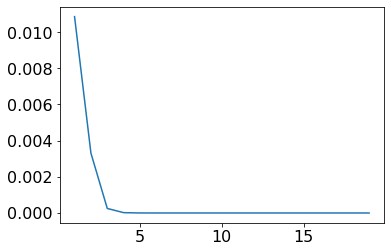

In [27]:
sz = len(err)
x = list( range(1,sz))
y = Cpp2Py(err)

plt.plot(x, y[1:])

<a name="error-1"></a>

In addition, one can use function `error` to comput the error for a given output, provided we know the target values

In [ ]:
ANN3.error(inputs, outputs)

## Exercise 1

Train an ANN to learn the exclusinve OR (XOR) gate:

| Input A | Input B |  Output A and B |
| --- | --- | --- |
|  0  |  0  |  0  |
|  0  |  1  |  1  |
|  0  |  1  |  1  |
|  1  |  1  |  0  |

Experiment with the ANN architecture and training parameters. Can you make the ANN with no hidden layers to learn this pattern?


## Exercise 2

Train an ANN to learn the quadratic function $y(x) = x^2$ on the [0, 5] interval. 

Hint: keep in mind that the output of the $tanh(x)$ function can be in the [-1, 1] interval, so you need to transform target y values into that interval. Even better, to something like [-0.5, 0.5]

Also, the best learning happens where the slope of the transfer function isn't too close to zero, so it is a good idea to convert the input variables into another range, e.g. [-1, 1]